In [ ]:
import os
import sys
sys.path.insert(0, "../bpodautopy/bpodautopy")

import db
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
dbe = db.Engine()

subjects = ['DIG-R-0015', 'DIG-R-0016', 'DIG-R-0017', 'DIG-R-0018']
thresholds = {
    'DIG-R-0015': 52875,
    'DIG-R-0016': 53036,
    'DIG-R-0017': 53451,
    'DIG-R-0018': 53625
} #thresholds of sessids when animals progressed to protocol. Will exclude pretraining from dataframes_trials

In [ ]:
dataframes_sess = {}
dataframes_trials = {}

#Extract variables for sessions of all subjects
for subject in subjects:
    query_sess = f"""
        SELECT x.subjid, x.hits, x.viols, x.num_trials, x.total_profit, x.sessid
        FROM beh.sessview x
        WHERE x.subjid = '{subject}'
        AND x.protocol = 'SoundITI2AFC_fm'
        AND x.sess_min IS NOT NULL
        AND x.sess_min != 0
        ORDER BY x.sessiondate ASC
    """
    dataframes_sess[subject] = pd.read_sql(query_sess, dbe)
#Correction of Values that are 0 because of missing Reward History for one Day (19.11.2024)
dataframes_sess['DIG-R-0015'].iloc[5, dataframes_sess['DIG-R-0015'].columns.get_loc('hits')] = 44.77
dataframes_sess['DIG-R-0016'].iloc[4, dataframes_sess['DIG-R-0016'].columns.get_loc('hits')] = 44.81
dataframes_sess['DIG-R-0017'].iloc[1, dataframes_sess['DIG-R-0017'].columns.get_loc('hits')] = 5.83
dataframes_sess['DIG-R-0018'].iloc[0, dataframes_sess['DIG-R-0018'].columns.get_loc('hits')] = 17.02

#Extracts variables for all trials for each subject
for subject in subjects:
    query_trials = f"""
        SELECT x.subjid, x.hit, x.viol, x.RT, x.n_pokes, x.sessid, x.parsed_events, x.trialid, x.data
        FROM beh.trialsview x
        WHERE subjid = '{subject}'
        AND x.sessid >= {thresholds[subject]}
        ORDER BY x.trialtime ASC
    """
    result = pd.read_sql(query_trials, dbe)
    dataframes_trials[subject] = result

df_trials = pd.concat(dataframes_trials, ignore_index=True)
df_trials = df_trials.set_index('subjid')
df_trials = df_trials.set_index('sessid', append=True)
df_trials = df_trials.set_index('trialid', append=True)

print("=== trial dataframe ===")
print(df_trials)


=== trial dataframe ===
                            hit  viol      RT  n_pokes  \
subjid     sessid trialid                                
DIG-R-0015 52875  10086672    0     1     NaN        2   
                  10086699    0     1     NaN        5   
                  10086733    0     1     NaN        6   
                  10086774    0     1     NaN        4   
                  10086806    0     1     NaN        1   
...                         ...   ...     ...      ...   
DIG-R-0018 56375  10760569    0     1     NaN        0   
                  10760671    0     1     NaN        2   
                  10760789    0     1     NaN        1   
                  10760889    0     1     NaN        2   
                  10760976    1     0  0.1928        3   

                                                                parsed_events  \
subjid     sessid trialid                                                       
DIG-R-0015 52875  10086672  b'{"vals":{"States":{"trialstar

In [94]:
for t, trial in enumerate(df_trials.index.get_level_values('trialid')):
    parsed_events = json.loads(df_trials.loc[df_trials.index.get_level_values('trialid')==trial, 'parsed_events'].item())['vals']['States']
    violation_type = np.nan
    for key, val in parsed_events.items():
        if (key.startswith('PreViolation')) & (val[1] is not None):
            violation_type = key
                
    for key, val in parsed_events.items():
        df_trials.loc[df_trials.index.get_level_values('trialid')==trial, key+'_tstamp'] = val[1]
    df_trials.loc[df_trials.index.get_level_values('trialid')==trial, 'violation_type'] = violation_type


    data = json.loads(df_trials.loc[df_trials.index.get_level_values('trialid')==trial, 'data'].item())['vals']
    for key, val in data.items():
        if (key != 'hit') & (key != 'viol') & (key != 'RT'):
            df_trials.loc[df_trials.index.get_level_values('trialid')==trial, key] = val

final dataframe

In [114]:
df_trials

hit  viol      RT  n_pokes  \
subjid     sessid trialid                                
DIG-R-0015 52875  10086672    0     1     NaN        2   
                  10086699    0     1     NaN        5   
                  10086733    0     1     NaN        6   
                  10086774    0     1     NaN        4   
                  10086806    0     1     NaN        1   
...                         ...   ...     ...      ...   
DIG-R-0018 56375  10760569    0     1     NaN        0   
                  10760671    0     1     NaN        2   
                  10760789    0     1     NaN        1   
                  10760889    0     1     NaN        2   
                  10760976    1     0  0.1928        3   

                                                                parsed_events  \
subjid     sessid trialid                                                       
DIG-R-0015 52875  10086672  b'{"vals":{"States":{"trialstart":[0,5],"PreVi...   
                  10086699  b'{"vals":{"States":{"trialstart":[0,2.5730999...   
                  10086733  b'{"vals":{"States":{"trialstart":[0,5],"PreVi...   
                  10086774  b'{"vals":{"States":{"trialstart":[0,4.3233000...   
                  10086806  b'{"vals":{"States":{"trialstart":[0,5],"PreVi...   
...                                                                       ...   
DIG-R-0018 56375  10760569  b'{"vals":{"States":{"trialstart":[0,5],"PreVi...   
                  10760671  b'{"vals":{"States":{"trialstart":[0,2.7196],"...   
                  10760789  b'{"vals":{"States":{"trialstart":[0,5],"PreVi...   
                  10760889  b'{"vals":{"States":{"trialstart":[0,0.4428],"...   
                  10760976  b'{"vals":{"States":{"trialstart":[0,0.5271],"...   

                                                                         data  \
subjid     sessid trialid                                                       
DIG-R-0015 52875  10086672  b'{"vals":{"n_done_trials":1,"hit":0,"viol":1,...   
                  10086699  b'{"vals":{"n_done_trials":2,"hit":0,"viol":1,...   
                  10086733  b'{"vals":{"n_done_trials":3,"hit":0,"viol":1,...   
                  10086774  b'{"vals":{"n_done_trials":4,"hit":0,"viol":1,...   
                  10086806  b'{"vals":{"n_done_trials":5,"hit":0,"viol":1,...   
...                                                                       ...   
DIG-R-0018 56375  10760569  b'{"vals":{"n_done_trials":46,"hit":0,"viol":1...   
                  10760671  b'{"vals":{"n_done_trials":47,"hit":0,"viol":1...   
                  10760789  b'{"vals":{"n_done_trials":48,"hit":0,"viol":1...   
                  10760889  b'{"vals":{"n_done_trials":49,"hit":0,"viol":1...   
                  10760976  b'{"vals":{"n_done_trials":50,"hit":1,"viol":0...   

                            trialstart  PreViolation_TrialStart  Violation  \
subjid     sessid trialid                                                    
DIG-R-0015 52875  10086672      5.0000                     5.01     5.0600   
                  10086699      2.5731                      NaN     2.6936   
                  10086733      5.0000                     5.01     5.0600   
                  10086774      4.3233                      NaN     9.5833   
                  10086806      5.0000                     5.01     5.0600   
...                                ...                      ...        ...   
DIG-R-0018 56375  10760569      5.0000                     5.01     5.0600   
                  10760671      2.7196                      NaN     3.2528   
                  10760789      5.0000                     5.01     5.0600   
                  10760889      0.4428                      NaN     0.6985   
                  10760976      0.5271                      NaN        NaN   

                                   ITI  ...  drink_state_in2_1_tstamp  \
subjid     sessid trialid               ...                             
DIG-

In [103]:
print(df_trials.columns)

Index(['hit', 'viol', 'RT', 'n_pokes', 'parsed_events', 'data', 'trialstart',
       'PreViolation_TrialStart', 'Violation', 'ITI', 'ChoiceSoundCue',
       'ChoicePortsPresented', 'PreRewardState', 'RewardState',
       'settle_in_rewardport0_1', 'rew_short_viol_1', 'settle_in_rewardport_1',
       'reward_delivery_1', 'drink_state_in_1', 'drink_state_in2_1',
       'drink_state_out_1', 'PreViolation_ChoiceSoundCue',
       'PreViolation_ChoicePortsPresented',
       'PreViolation_TimeoutChoicePortsPresented', 'violation_type',
       'trialstart_tstamp', 'PreViolation_TrialStart_tstamp',
       'Violation_tstamp', 'ITI_tstamp', 'ChoiceSoundCue_tstamp',
       'ChoicePortsPresented_tstamp', 'PreRewardState_tstamp',
       'RewardState_tstamp', 'settle_in_rewardport0_1_tstamp',
       'rew_short_viol_1_tstamp', 'settle_in_rewardport_1_tstamp',
       'reward_delivery_1_tstamp', 'drink_state_in_1_tstamp',
       'drink_state_in2_1_tstamp', 'drink_state_out_1_tstamp',
       'PreViolatio

In [162]:
import seaborn as sns
# pip install statannotations
from statannotations.Annotator import Annotator
import itertools

In [106]:
plt.rcParams.update({'font.size': 22})

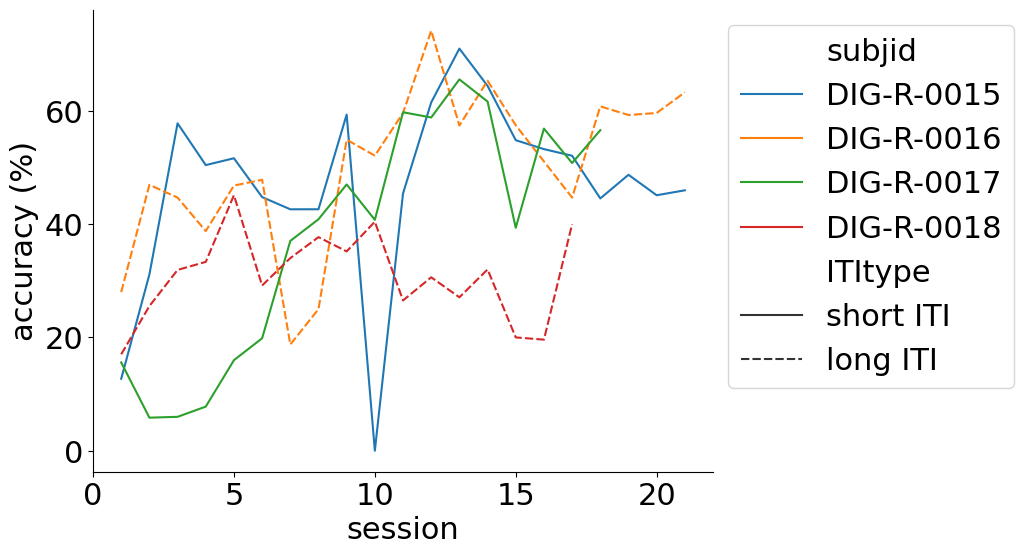

In [153]:
df_trials['session'] = df_trials.reset_index().groupby('subjid')['sessid'].rank(method='dense', ascending=True).astype(int).values
df_trials['ITItype'] = df_trials['ITI'].map(lambda x: 'long ITI' if x>50 else 'short ITI')
fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(
    ax=ax,
    data=df_trials,
    x='session',
    y='hit',
    hue='subjid',
    style='ITItype',
    errorbar=None,
    estimator=lambda x: sum(x)*100.0/len(x),
)
# handles, labels = plt.gca().get_legend_handles_labels()
# plt.legend(handles[1:5], labels[1:5])
plt.ylabel('accuracy (%)')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
sns.despine(fig=fig)
plt.show()

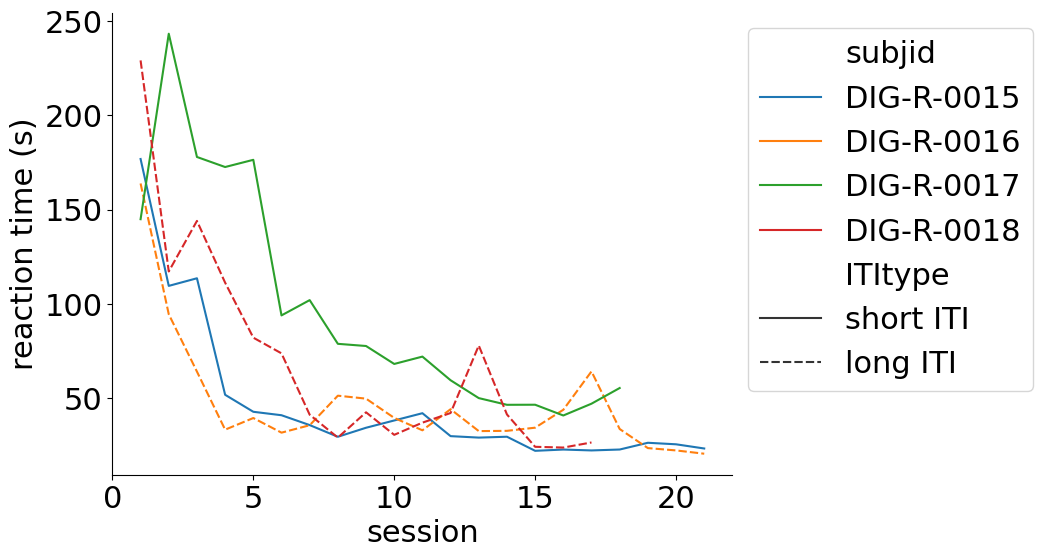

In [154]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(
    ax=ax,
    data=df_trials,
    x='session',
    y='RT',
    hue='subjid',
    style='ITItype',
    errorbar=None,
    estimator=lambda x: sum(x)*100.0/len(x),
)
# handles, labels = plt.gca().get_legend_handles_labels()
# plt.legend(handles[1:5], labels[1:5])
plt.ylabel('reaction time (s)')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
sns.despine(fig=fig)
plt.show()

cannot compare with t-test as there is no null case

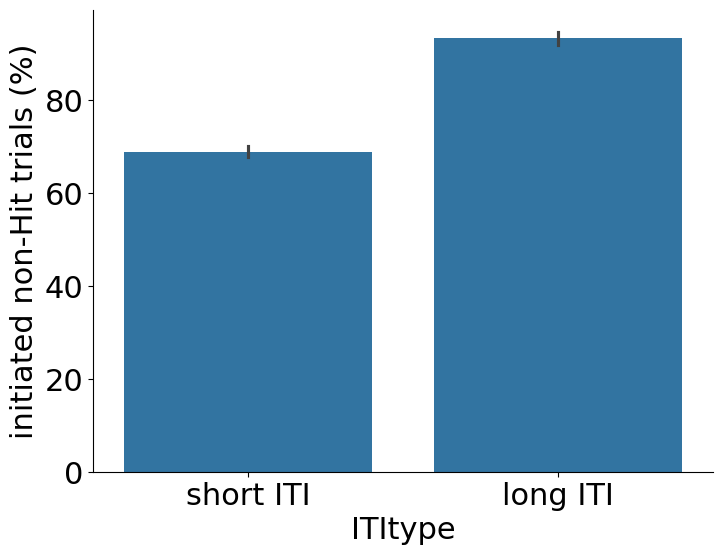

In [180]:
df_trials['initiated trial'] = True
df_trials.loc[df_trials['n_pokes']==0, 'initiated trial'] = False

fig, ax = plt.subplots(figsize=(8, 6))
plt_kwargs = dict(
    ax=ax,
    data=df_trials.loc[df_trials['choice']=='Violation', :],
    x='ITItype',
    y='initiated trial',
    estimator=lambda x: sum(x)*100.0/len(x),
)
sns.barplot(**plt_kwargs)

# pairs = [("short ITI",), ("long ITI",)]
# annot = Annotator(pairs=pairs, **plt_kwargs)
# annot.configure(test='t-test_ind', verbose=2)
# annot.apply_and_annotate()

plt.ylabel('initiated non-Hit trials (%)')
sns.despine(fig=fig)
plt.show()